In [3]:
import os
import zipfile
import numpy as np
import pandas as pd
from collections import defaultdict
from pathlib import Path
import matplotlib.pyplot as plt
from nilearn import datasets
import re
import pickle
import ipywidgets as widgets
from scipy.stats import shapiro, norm # checking normality
from ipywidgets import interactive, IntSlider
import seaborn as sns
import shutil

## The question - 

HOW DO WE KNOW THAT A MATRIX IS AN OUTLIER?

Decription of project

 ### some ideas 
 - Check whether cell covariates with others?
 - Get a null distribution of correlations between matrixes, to check 
 - Gaussian processes or kernel machines
 - How many times do we need to repeat the ICA_AROMA to get a true distribution?




## LOOK AT DATA

subject_matrices.pkl contains all the individual correlation matrixes for the 100 iterations

subject_statistics.pkl contains the summaries

1. FalseComb0 - ica_aroma=false, confounds_removal=None,
2. FalseComb1 - ica_aroma=false, confounds_removal=["a_comp_cor_0[0-4]"],
3. FalseComb2 - ica_aroma=false, confounds_removal=["(trans|rot)_[xyz]"],
4. FalseComb3 - ica_aroma=false, confounds_removal=["(trans|rot)_[xyz]", "(trans|rot)_[xyz]_derivative1", "(trans|rot)_[xyz]_power2","(trans|rot)_[xyz]_derivative1_power2"],
5. FalseComb4 - ica_aroma=false, confounds_removal=["(trans|rot)_[xyz]", "(trans|rot)_[xyz]_derivative1", "(trans|rot)_[xyz]_power2","(trans|rot)_[xyz]_derivative1_power2","global_signal"],
6. FalseComb5 - ica_aroma=false, confounds_removal=["global_signal"],
7. TrueComb0 - ica_aroma=true, confounds_removal=None,
8. TrueComb1 - ica_aroma=true, confounds_removal=["a_comp_cor_0[0-4]"],
9. TrueComb2 - ica_aroma=true, confounds_removal=["(trans|rot)_[xyz]"],
10. TrueComb3 - ica_aroma=true, confounds_removal=["(trans|rot)_[xyz]", "(trans|rot)_[xyz]_derivative1", "(trans|rot)_[xyz]_power2","(trans|rot)_[xyz]_derivative1_power2"],
11. TrueComb4 - ica_aroma=true, confounds_removal=["(trans|rot)_[xyz]", "(trans|rot)_[xyz]_derivative1", "(trans|rot)_[xyz]_power2","(trans|rot)_[xyz]_derivative1_power2","global_signal"],
12. TrueComb5 - ica_aroma=true, confounds_removal=["global_signal"],

### 0. LOAD DATA

In [4]:
with open("subject_matrices.pkl", "rb") as f:
    all_subjects = pickle.load(f)

with open("subject_statistics.pkl", "rb") as f:
    loaded_data = pickle.load(f)

subject_averages = loaded_data["subject_averages"]
subject_counts = loaded_data["subject_counts"]
subject_avg_deviations = loaded_data["subject_deviations"]
subject_worst = loaded_data["subject_worst_cases"]

In [5]:
print(all_subjects.keys())

dict_keys(['sub-9040', 'sub-13192', 'sub-01'])


In [6]:
print(loaded_data.keys())
print(subject_averages.keys())

#Overview of the file

for subject_id, categories in subject_averages.items():
    print(f"Subject: {subject_id}")
    for category in categories.keys():
        print(f"  Category: {category} with {subject_counts[subject_id][category]} iterations")

dict_keys(['subject_averages', 'subject_deviations', 'subject_worst_cases', 'subject_counts'])
dict_keys(['sub-9040', 'sub-13192', 'sub-01'])
Subject: sub-9040
  Category: TrueComb2 with 100 iterations
  Category: FalseComb5 with 100 iterations
  Category: FalseComb2 with 100 iterations
  Category: TrueComb5 with 100 iterations
  Category: FalseComb3 with 100 iterations
  Category: TrueComb4 with 100 iterations
  Category: TrueComb3 with 100 iterations
  Category: FalseComb4 with 100 iterations
  Category: FalseComb1 with 100 iterations
  Category: TrueComb1 with 100 iterations
  Category: TrueComb0 with 100 iterations
  Category: FalseComb0 with 100 iterations
Subject: sub-13192
  Category: TrueComb2 with 99 iterations
  Category: FalseComb1 with 99 iterations
  Category: TrueComb5 with 99 iterations
  Category: FalseComb0 with 99 iterations
  Category: TrueComb4 with 99 iterations
  Category: TrueComb3 with 99 iterations
  Category: FalseComb2 with 99 iterations
  Category: FalseComb

### 1. We look at averages and standard deviations of cells (in subject_statistics.pkl)

#### FUNCTIONS

Do we want to maybe include some metrics in display_heat map? average? 

In [21]:

def display_heatmap(ax, subject_id, category, matrix_type='averages'):
    """
    Display a heatmap for a specific subject and category on a given axis.

    Parameters:
    ax (matplotlib.axes._axes.Axes): The axis to plot the heatmap on.
    subject_id (str): The subject ID.
    category (str): The category name.
    matrix_type (str): The type of matrix to display ('averages', 'deviations', 'worst').
    """
    if matrix_type == 'averages':
        matrix = subject_averages[subject_id][category]
        cmap = "coolwarm"
        vmin, vmax = -1, 1
    elif matrix_type == 'deviations':
        matrix = subject_avg_deviations[subject_id][category]
        cmap = "viridis"
        vmin, vmax = 0, 0.4
    elif matrix_type == 'worst':
        matrix = subject_worst[subject_id][category]
        cmap = "plasma"
        vmin, vmax = 0, 1.3
    else:
        raise ValueError("Invalid matrix_type. Choose from 'averages', 'deviations', 'worst'.")

    count = subject_counts[subject_id][category]
    
    cax = ax.imshow(matrix, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    ax.set_title(f"{category} ({count} matrices)")
    ax.set_xlabel("Schaefer Atlas Regions")
    ax.set_ylabel("Schaefer Atlas Regions")
    
    # Set network names on the axes at their first occurrence
    ax.set_xticks(network_indices)
    ax.set_yticks(network_indices)
    ax.set_xticklabels(unique_networks, rotation=90)
    ax.set_yticklabels(unique_networks)
    
    return cax


def update_category_dropdown(*args):
    subject_id = subject_dropdown.value
    category_dropdown.options = list(subject_averages[subject_id].keys())


def plot_all_combinations(subject_id, matrix_type='averages'):
    """
    Plots correlation matrices for all preprocessing strategies for one subject.

    Parameters:
    subject_id (str): The subject ID for which to plot the combinations.
    matrix_type (str): The type of matrix to display ('averages', 'deviations', 'worst').
    """
    if matrix_type == 'averages':
        categories = sorted(list(subject_averages[subject_id].keys()))
    elif matrix_type == 'deviations':
        categories = sorted(list(subject_avg_deviations[subject_id].keys()))
    elif matrix_type == 'worst':
        categories = sorted(list(subject_worst[subject_id].keys()))
    else:
        raise ValueError("Invalid matrix_type. Choose from 'averages', 'deviations', 'worst'.")

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    axes = axes.flatten()
    
    for i, category in enumerate(categories):
        cax = display_heatmap(axes[i], subject_id, category, matrix_type)
        axes[i].set_title(f"{category} ({subject_id} matrices)")
        fig.colorbar(cax, ax=axes[i])
    
    plt.tight_layout()
    plt.show()
    

def find_highest_values(data_dict):
    highest_values = {}
    for subject_id, categories in data_dict.items():
        highest_values[subject_id] = {}
        for category, matrix in categories.items():
            max_value = np.nanmax(matrix)
            min_value = np.nanmin(matrix)
            highest_values[subject_id][category] = (max_value, min_value)
    return highest_values

def print_highest_values(title, highest_values):
    print(f"\n{title}\n" + "="*len(title))
    for subject_id, categories in highest_values.items():
        for category, (max_value, min_value) in categories.items():
            print(f"Subject: {subject_id}, Category: {category}, Max Value: {max_value}, Min Value: {min_value}")




def plot_cell_distribution(subject_id, category, cell_indices):
    """
    Plot the distribution of values for specific cells in the matrices for a given subject and category.

    Parameters:
        subject_id (str): The subject ID.
        category (str): The category name.
        cell_indices (list of tuples or tuple): List of cell indices (i, j) to plot.
    """
    
    matrices = np.array(all_subjects[subject_id][category])
    cell_indices = np.atleast_1d(cell_indices)  # Ensure cell_indices is always treated as an array
    num_cells = len(cell_indices)
    
    fig, axes = plt.subplots(1, num_cells, figsize=(5 * num_cells, 5))
    
    if num_cells == 1:
        axes = [axes]
    
    for ax, (i, j) in zip(axes, cell_indices):
        cell_values = matrices[:, i, j]
        sns.histplot(cell_values, ax=ax, kde=False, stat='count', bins=15)
        ax.set_title(f'Cell ({i}, {j}) Distribution\n{subject_id} - {category}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()




#### SCHAEFFER LABELLING

In [8]:
## Schaeffer labels
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=1)
labels = [label.decode('utf-8') for label in schaefer_atlas.labels]  # decode bytes to string if necessary

# Extract general network names (removing hemisphere and specific region numbers)
network_names = [label.split('_')[2] for label in labels]
network_names_with_hemisphere = ['_'.join(label.split('_')[1:3]) for label in labels]

# Find unique network names and the first index they appear at for plotting
unique_networks = []
network_indices = []
for index, name in enumerate(network_names_with_hemisphere):
    if name not in unique_networks:
        unique_networks.append(name)
        network_indices.append(index)

#### INSPECT THE DATA

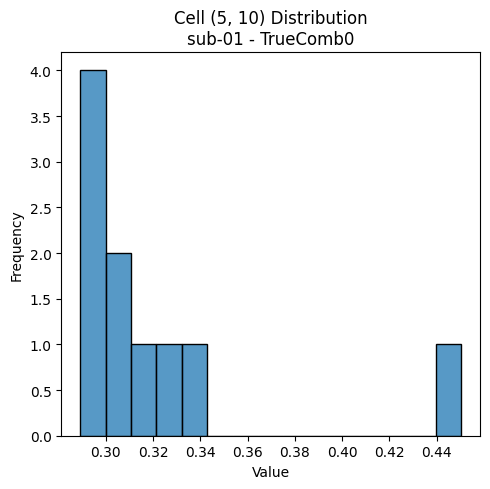

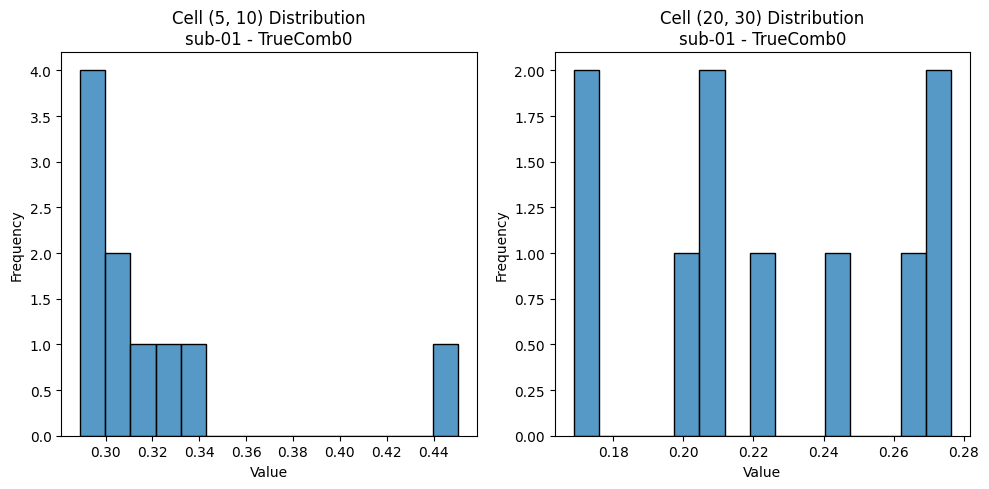

In [22]:

# Example usage
plot_cell_distribution('sub-01', 'TrueComb0', [(5, 10)])
plot_cell_distribution('sub-01', 'TrueComb0', [(5, 10), (20, 30)])

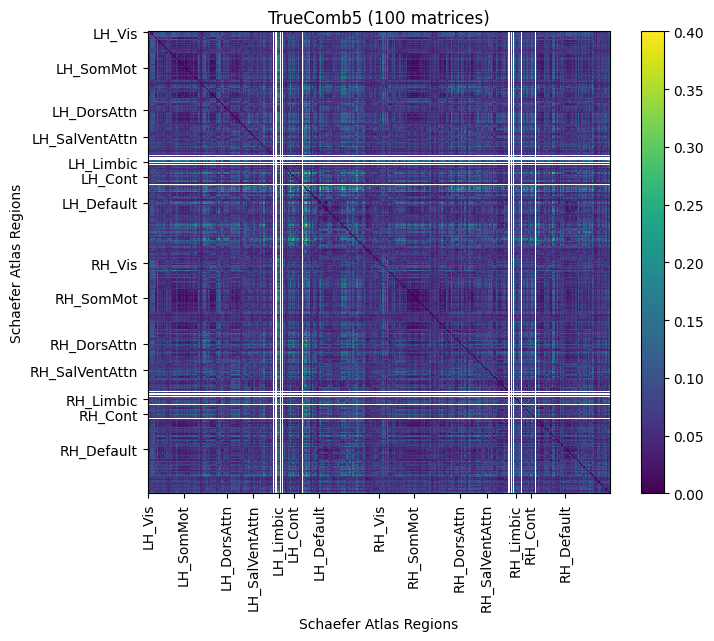

In [19]:

# Display a heatmap of one of the averages
subject_id = list(subject_avg_deviations.keys())[0]
category = list(subject_avg_deviations[subject_id].keys())[3]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
cax = display_heatmap(ax, subject_id, category, matrix_type='deviations')
fig.colorbar(cax)  # add colorbar
plt.show()



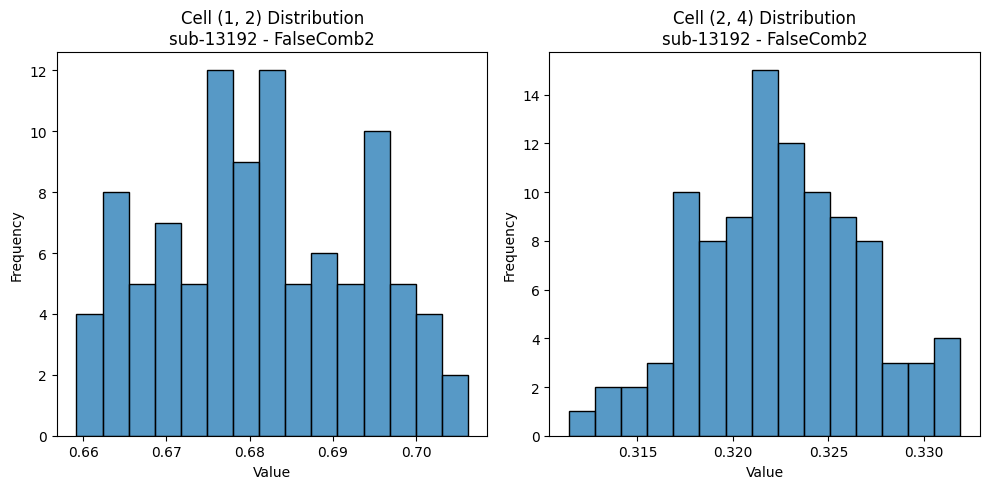

In [19]:
#plot_cell_distribution("sub-13192", "FalseComb2", cell_indices=((1,2)))
plot_cell_distribution("sub-13192", "FalseComb2", cell_indices=((1,2), (2,4)))

In [191]:
# Find the highest values in subject_avg_deviations and subject_worst
highest_deviations = find_highest_values(subject_avg_deviations)
highest_worst_cases = find_highest_values(subject_worst)

print_highest_values("Highest Deviations", highest_deviations)
print_highest_values("Highest Worst Cases", highest_worst_cases)


Highest Deviations
Subject: sub-9040, Category: TrueComb2, Max Value: 0.3576248956918261, Min Value: 0.0
Subject: sub-9040, Category: FalseComb5, Max Value: 0.09417272163035637, Min Value: 0.0
Subject: sub-9040, Category: FalseComb2, Max Value: 0.07480877159303895, Min Value: 0.0
Subject: sub-9040, Category: TrueComb5, Max Value: 0.36419078810412214, Min Value: 0.0
Subject: sub-9040, Category: FalseComb3, Max Value: 0.08380729746519334, Min Value: 0.0
Subject: sub-9040, Category: TrueComb4, Max Value: 0.4026671777152118, Min Value: 0.0
Subject: sub-9040, Category: TrueComb3, Max Value: 0.33775463303285913, Min Value: 0.0
Subject: sub-9040, Category: FalseComb4, Max Value: 0.10677980189585964, Min Value: 0.0
Subject: sub-9040, Category: FalseComb1, Max Value: 0.13687050346385685, Min Value: 0.0
Subject: sub-9040, Category: TrueComb1, Max Value: 0.3903334159692871, Min Value: 0.0
Subject: sub-9040, Category: TrueComb0, Max Value: 0.34820188762486004, Min Value: 0.0
Subject: sub-9040, Ca

In [28]:
# Get a list of (subject, category) tuples
subject_category_pairs = [(subject, category) for subject in subject_averages for category in subject_averages[subject]]

def display_heatmap_interactive(index):
    subject_id, category = subject_category_pairs[index]
    count = subject_counts[subject_id][category]
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = display_heatmap(ax, subject_id, category)
    ax.set_title(f"Heatmap of Average Correlation Matrix ({subject_id} - {category})\nNumber of matrices: {count}")
    fig.colorbar(cax)
    
    plt.show()

# Create interactive widgets
subject_dropdown = widgets.Select(options=list(subject_averages.keys()), description='Subject:')
category_dropdown = widgets.Select(description='Category:', rows=10)
subject_dropdown.observe(update_category_dropdown, 'value')

# Initial update to populate the category dropdown
update_category_dropdown()

# Create an interactive slider and plot
index_slider = widgets.IntSlider(min=0, max=len(subject_category_pairs)-1, description='Index')
interactive_plot = interactive(display_heatmap_interactive, index=index_slider,  subject_id=subject_dropdown, category=category_dropdown)

display(interactive_plot)


interactive(children=(IntSlider(value=0, description='Index', max=35), Output()), _dom_classes=('widget-intera…

In [23]:
subject_select = widgets.Select(options=list(subject_averages.keys()), description='Subject:', rows=10)
matrix_type_select = widgets.Dropdown(options=['averages', 'deviations', 'worst'], description='Matrix Type:')
interactive_plot = interactive(plot_all_combinations, subject_id=subject_select, matrix_type=matrix_type_select)
output = interactive_plot.children[-1]
output.layout.height = '1000px'  # Increase the height for better visibility of all plots
display(interactive_plot)

interactive(children=(Select(description='Subject:', options=('sub-9040', 'sub-13192', 'sub-01'), rows=10, val…

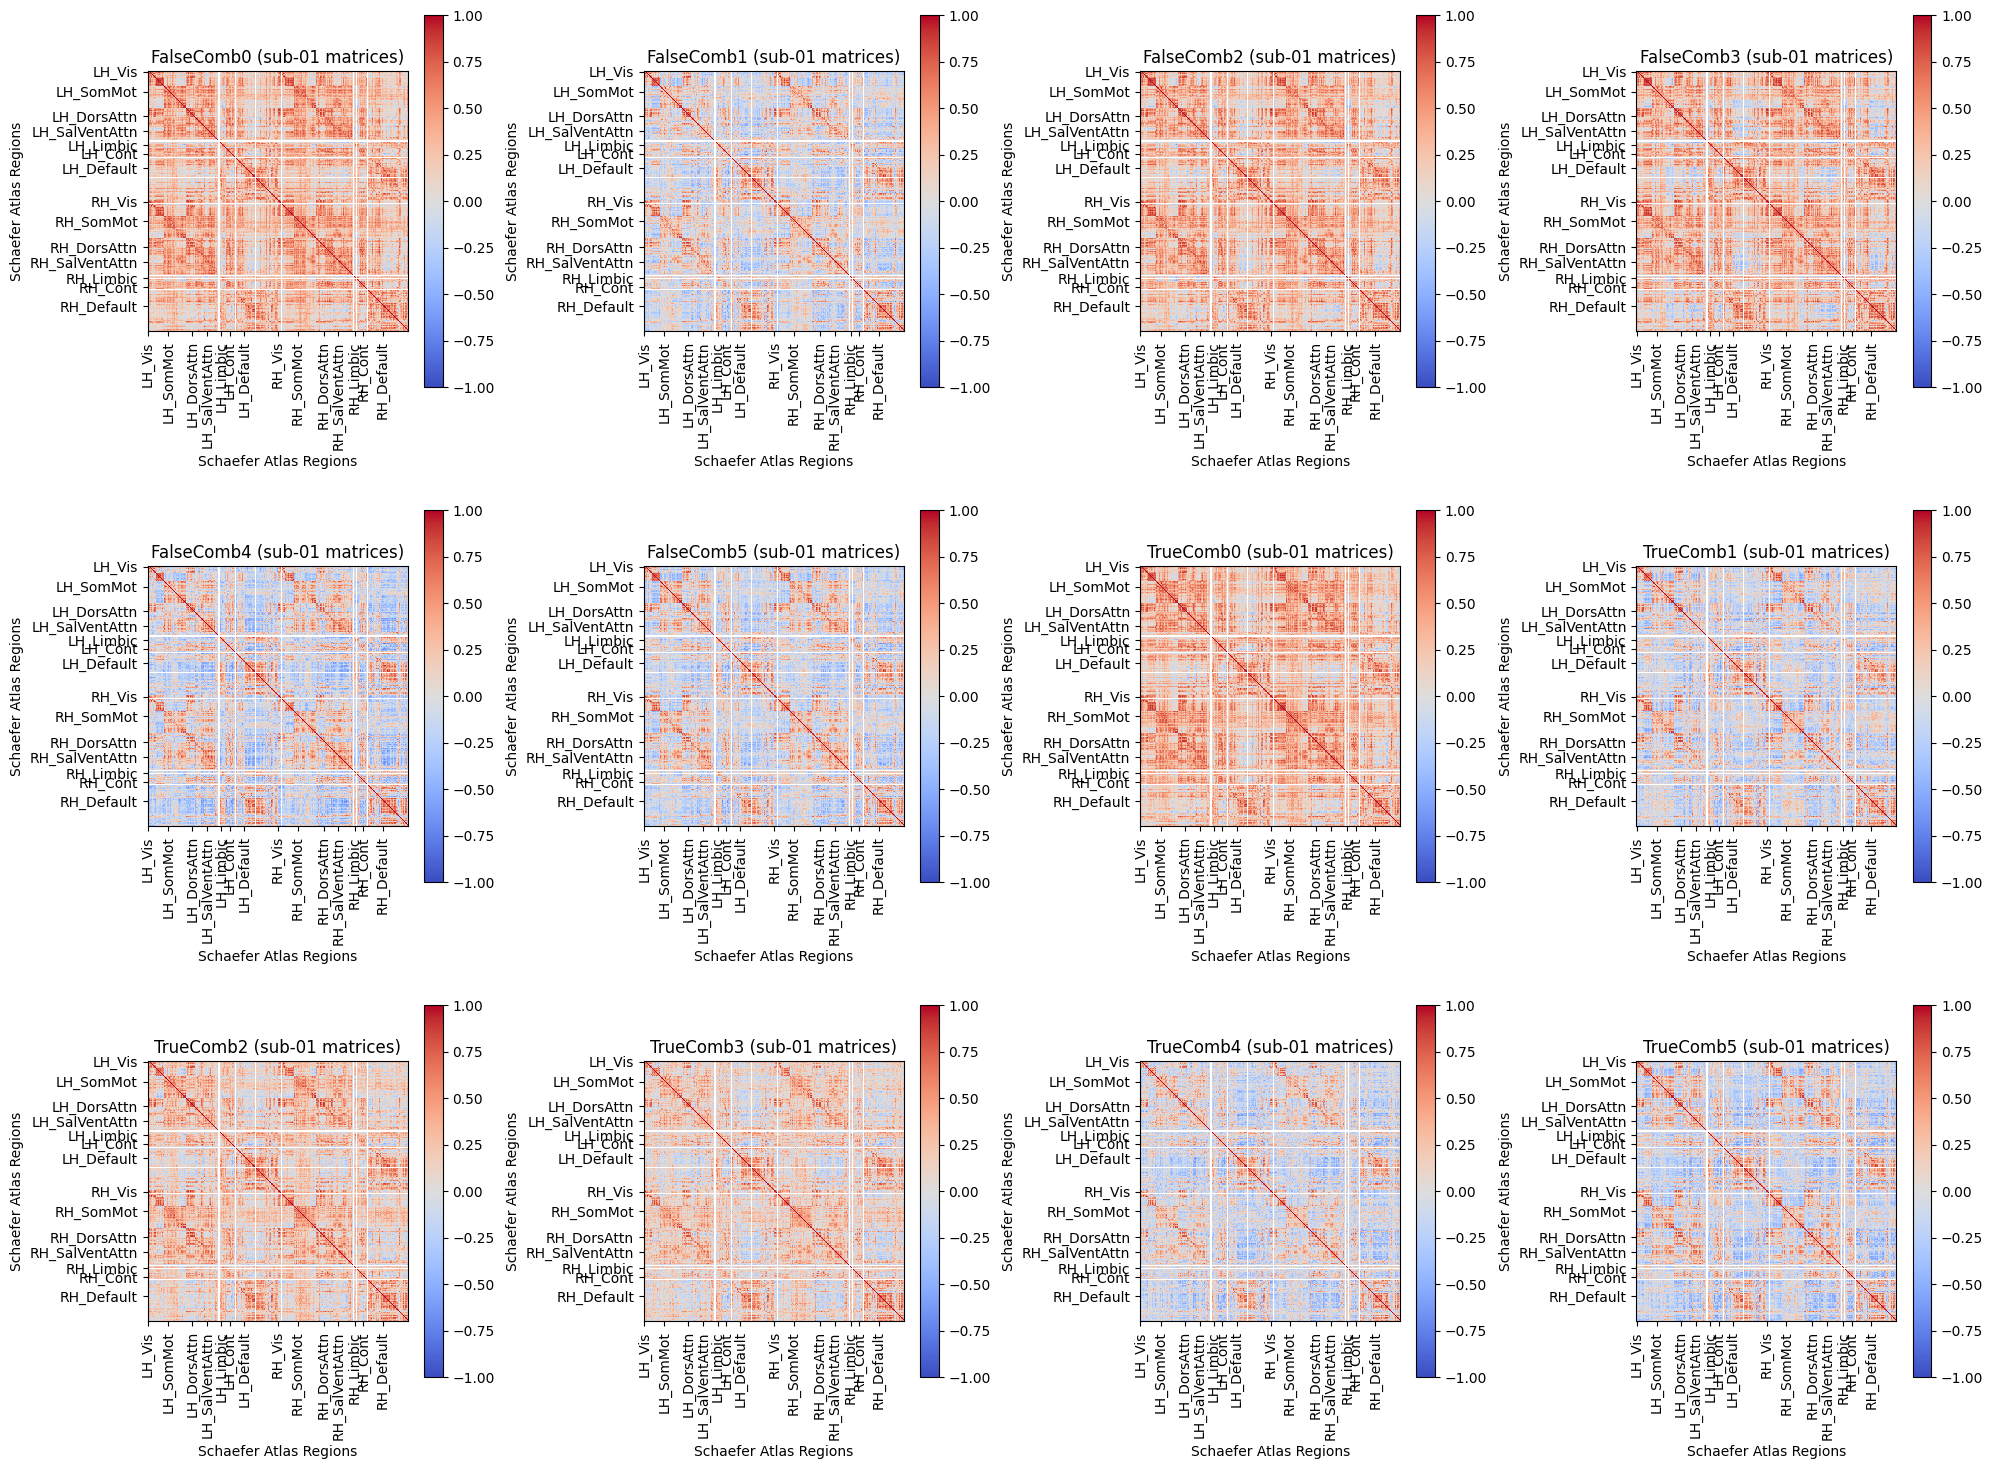

In [8]:
plot_all_combinations("sub-01")

### 2. We look at distrubution of cells with high standard deviations (in subject_matrices.pkl)

In [20]:
with open("subject_matrices.pkl", "rb") as f:
    all_subjects = pickle.load(f)

sub-13192 FalseComb1


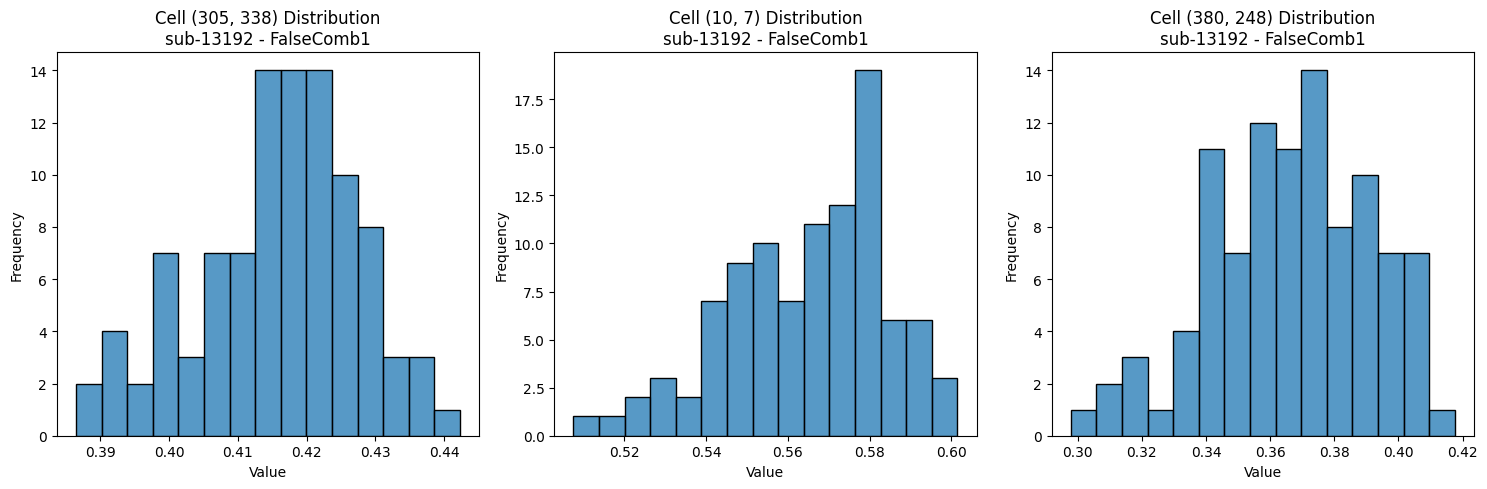

In [24]:
subject_id = list(all_subjects.keys())[1]
category = list(all_subjects[subject_id].keys())[1]
cell_indices = [(305, 338), (10, 7), (380, 248)]  # Example cell indices to plot

print(subject_id, category)
plot_cell_distribution('sub-13192', category, cell_indices)

In [13]:
def calculate_std_deviation(subject_id, category):
    """
    Calculate the standard deviation of values for all off-diagonal, non-duplicate cells 
    in the upper triangular part of the matrices for a given subject and category.
    
    Returns:
    tuple: A tuple containing the number of cells with high standard deviation, 
           the percentage of such cells, and a list of tuples (i, j) with high standard deviation.
    """
    matrices = np.array(all_subjects[subject_id][category])
    high_std_cells = []
    std_devs = []
    rows, cols = matrices.shape[1], matrices.shape[2]
    threshold = 0.1  # Define a threshold for what we consider HIGH std
    
    for i in range(rows):
        for j in range(i + 1, cols):  # Only consider the upper triangular part excluding the diagonal
            cell_values = matrices[:, i, j]
            
            std_dev = np.std(cell_values)
            if std_dev > threshold:  # Threshold for high standard deviation
                high_std_cells.append((i, j))
                std_devs.append(std_dev)
    
    high_std_count = len(high_std_cells)
    total_upper_triangular_cells = rows * (rows - 1) // 2
    high_std_percentage = (high_std_count / total_upper_triangular_cells) * 100
    
    return high_std_count, high_std_percentage, high_std_cells, std_devs

def check_all_subjects_conditions():
    """
    Check the standard deviation of values for all off-diagonal, non-duplicate cells 
    in all matrices for all subjects and categories.
    
    Returns:
    dict: A dictionary where keys are (subject_id, category) tuples and values are dictionaries with 
          'count', 'percentage', 'cells', and 'std_devs' keys.
    """
    high_std_results = {}
    
    for subject_id in all_subjects.keys():
        for category in all_subjects[subject_id].keys():
            high_std_count, high_std_percentage, high_std_cells, std_devs = calculate_std_deviation(subject_id, category)
            high_std_results[(subject_id, category)] = {
                'count': high_std_count,
                'percentage': high_std_percentage,
                'cells': high_std_cells,
                'std_devs': std_devs
            }
    
    return high_std_results

def plot_high_std_distributions(high_std_results, top_n=5):
    """
    Plot the distributions of the cells with the highest standard deviations for visualization.
    """
    for subject_id, category in sorted_keys:
        data = high_std_results[(subject_id, category)]
        high_std_cells = data['cells']
        std_devs = data['std_devs']
        
        # Sort by standard deviations to get the cells with the highest std deviations
        sorted_indices = np.argsort(std_devs)[::-1]
        top_high_std_cells = [high_std_cells[i] for i in sorted_indices[:top_n]]
        
        for cell in top_high_std_cells:
            i, j = cell
            cell_values = np.array(all_subjects[subject_id][category])[:, i, j]
            
            plt.figure(figsize=(10, 6))
            sns.histplot(cell_values, kde=False, stat='count', bins=20)  # Use 'count' for correct histogram
            mu, std = np.mean(cell_values), np.std(cell_values)
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            plt.plot(x, p * len(cell_values) * (xmax - xmin) / 20, 'k', linewidth=2)  # Adjust the plot to match histogram
            title = f"Distribution of cell ({i}, {j}) in {subject_id} - {category} with std dev {std:.4f}"
            plt.title(title)
            plt.xlabel("Cell Values")
            plt.ylabel("Count")
            plt.show()



Subject: sub-01, Category: FalseComb0, High std cells count: 0, Percentage: 0.00%
Subject: sub-01, Category: FalseComb1, High std cells count: 0, Percentage: 0.00%
Subject: sub-01, Category: FalseComb2, High std cells count: 0, Percentage: 0.00%
Subject: sub-01, Category: FalseComb3, High std cells count: 0, Percentage: 0.00%
Subject: sub-01, Category: FalseComb4, High std cells count: 0, Percentage: 0.00%
Subject: sub-01, Category: FalseComb5, High std cells count: 0, Percentage: 0.00%
Subject: sub-01, Category: TrueComb0, High std cells count: 1142, Percentage: 1.43%
Subject: sub-01, Category: TrueComb1, High std cells count: 2289, Percentage: 2.87%
Subject: sub-01, Category: TrueComb2, High std cells count: 2425, Percentage: 3.04%
Subject: sub-01, Category: TrueComb3, High std cells count: 11042, Percentage: 13.84%
Subject: sub-01, Category: TrueComb4, High std cells count: 9766, Percentage: 12.24%
Subject: sub-01, Category: TrueComb5, High std cells count: 1547, Percentage: 1.94%
S

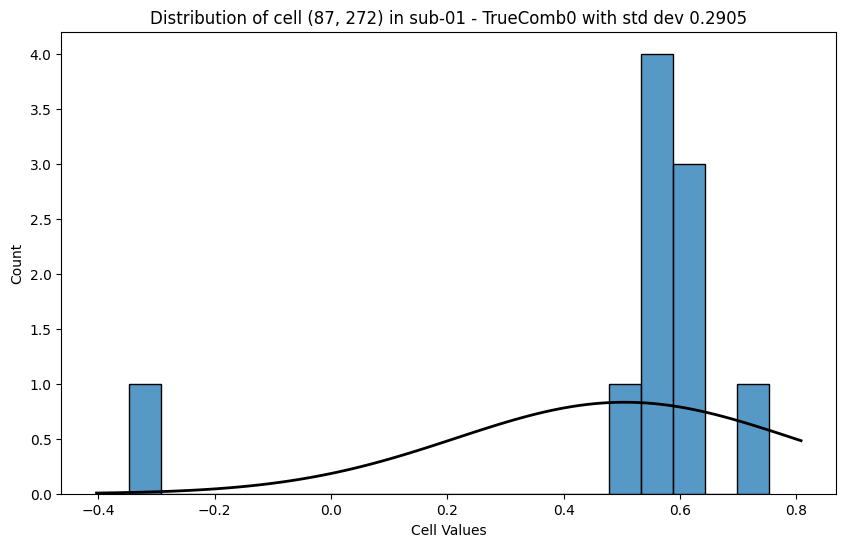

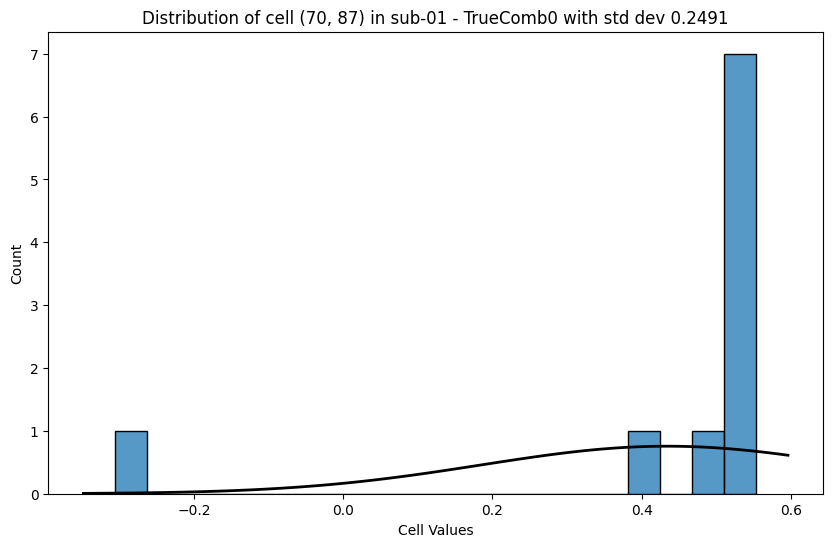

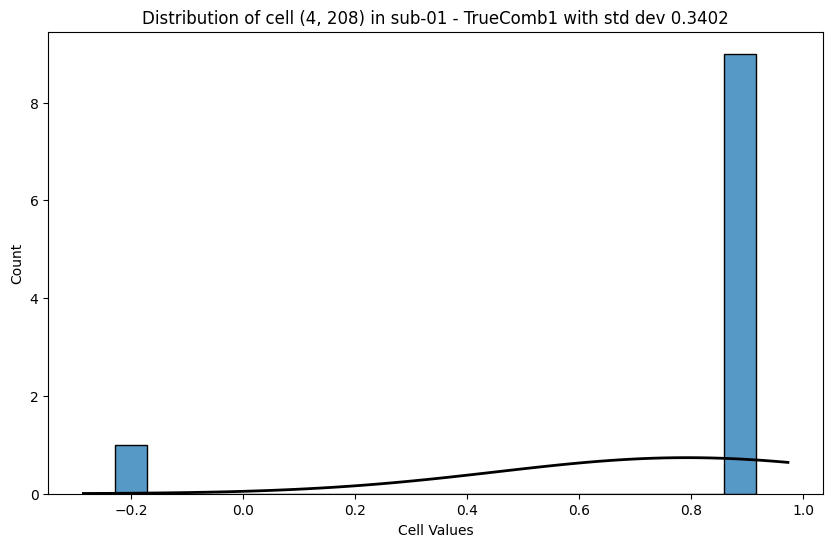

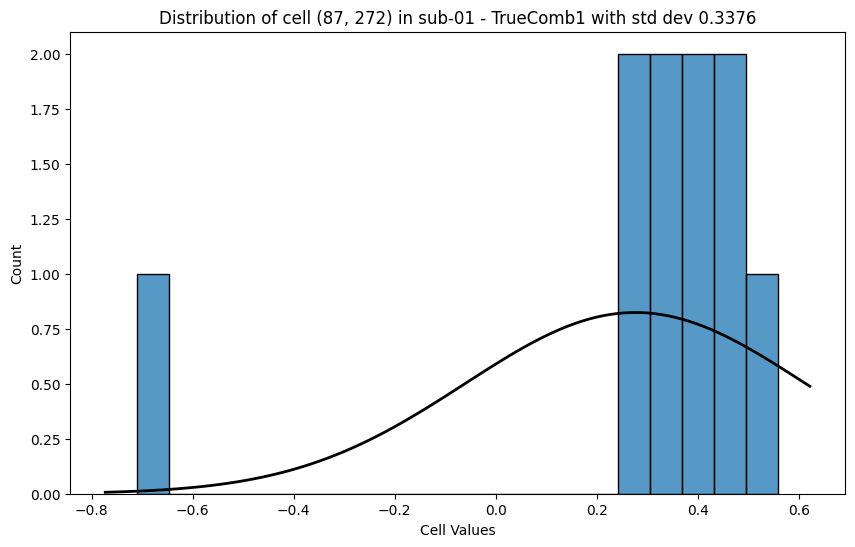

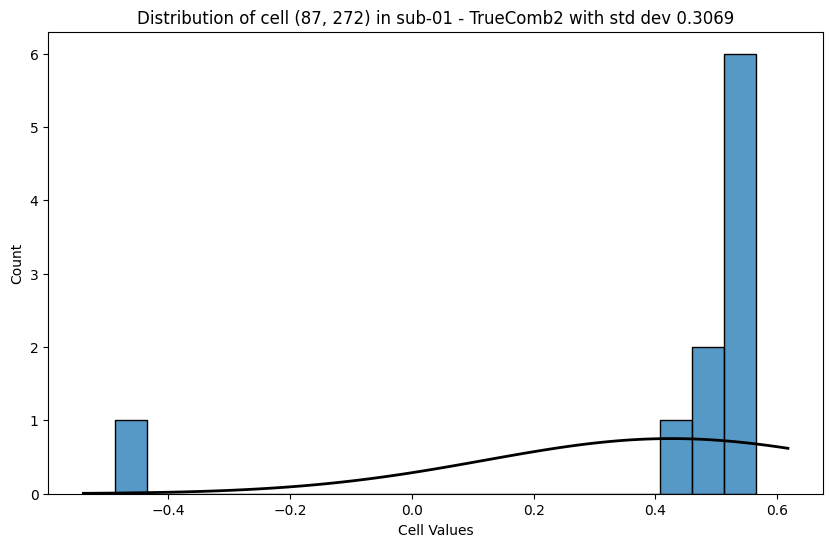

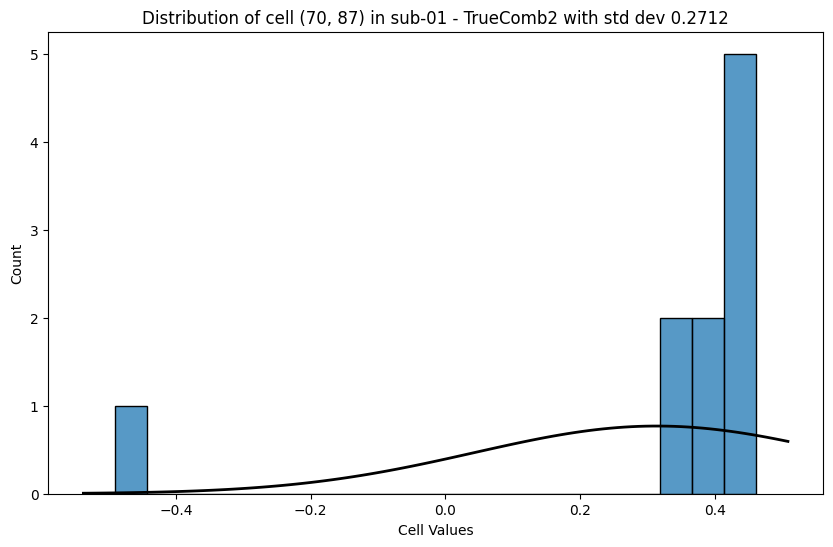

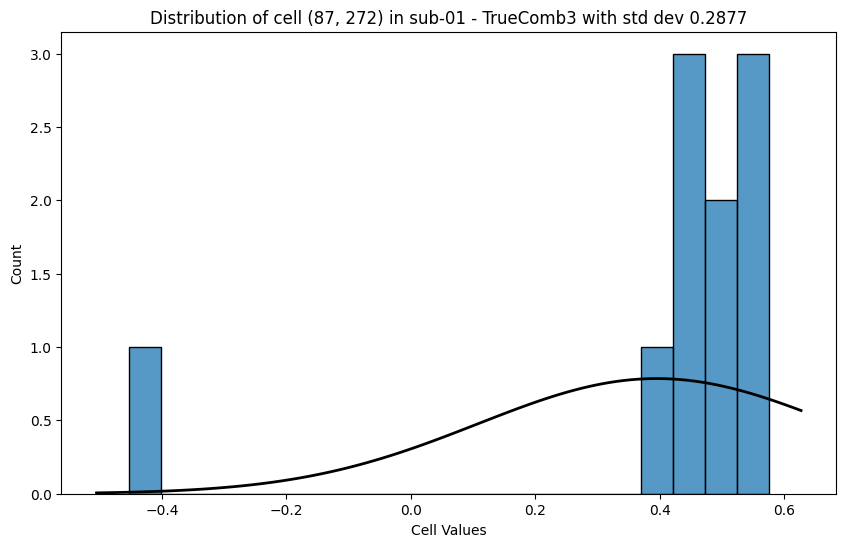

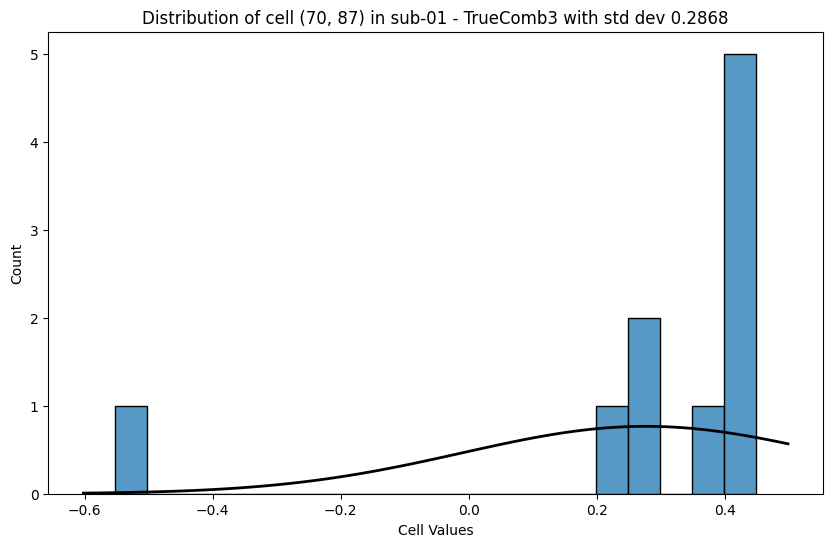

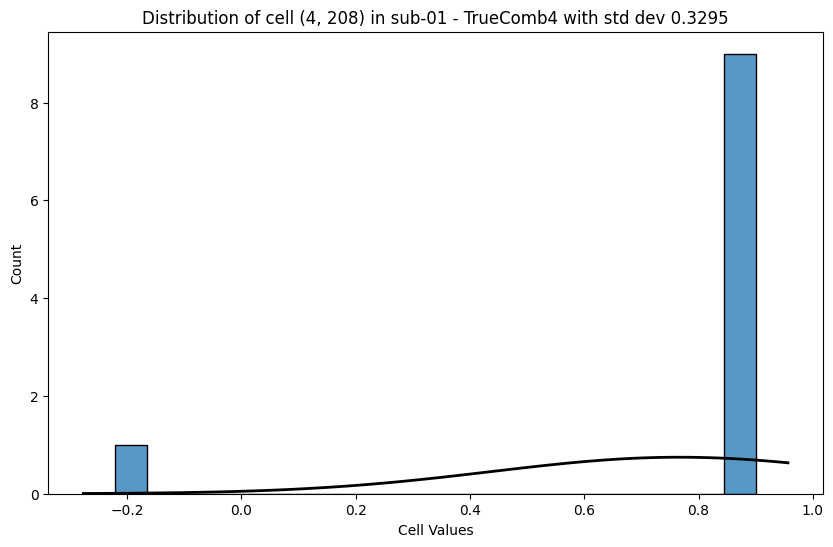

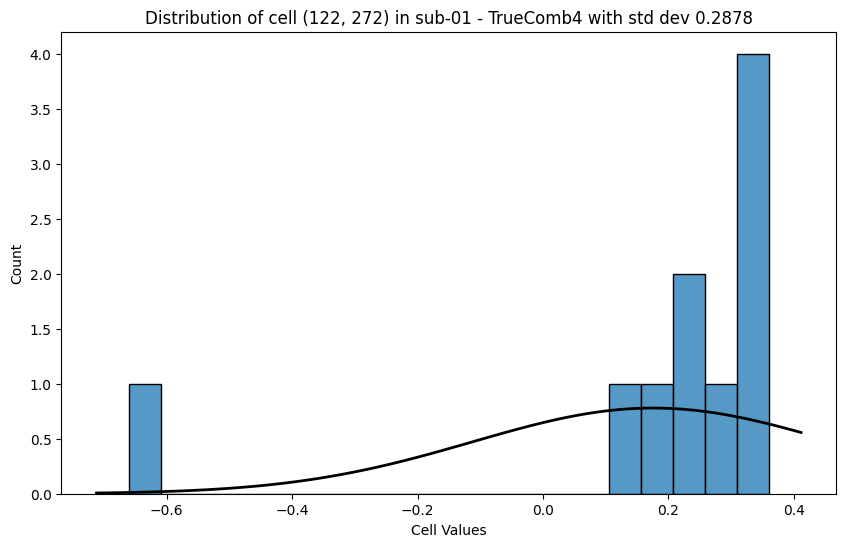

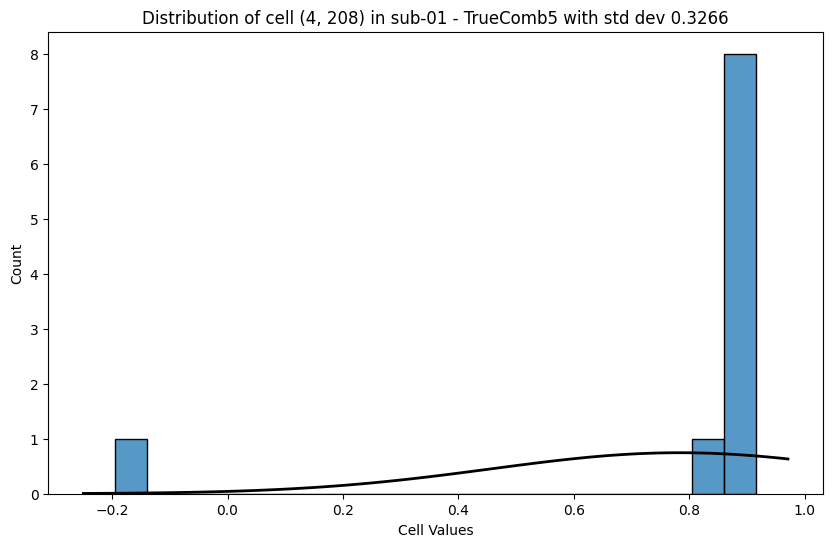

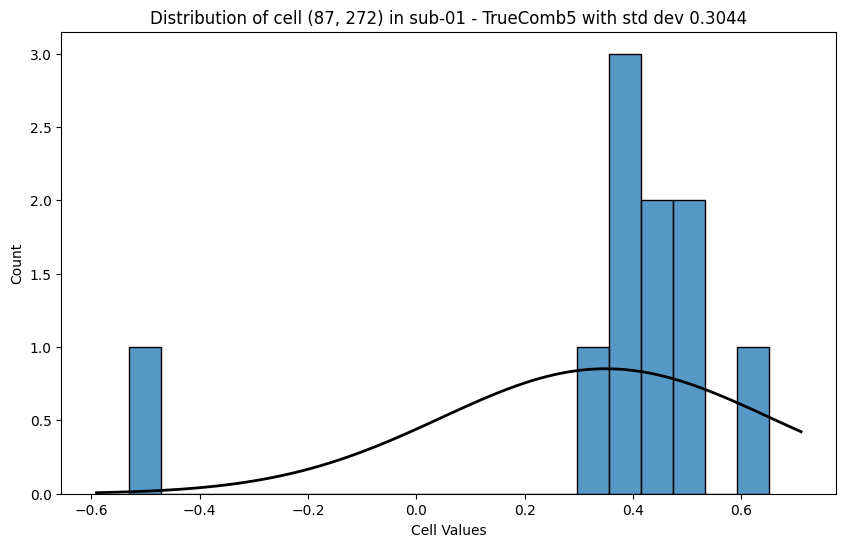

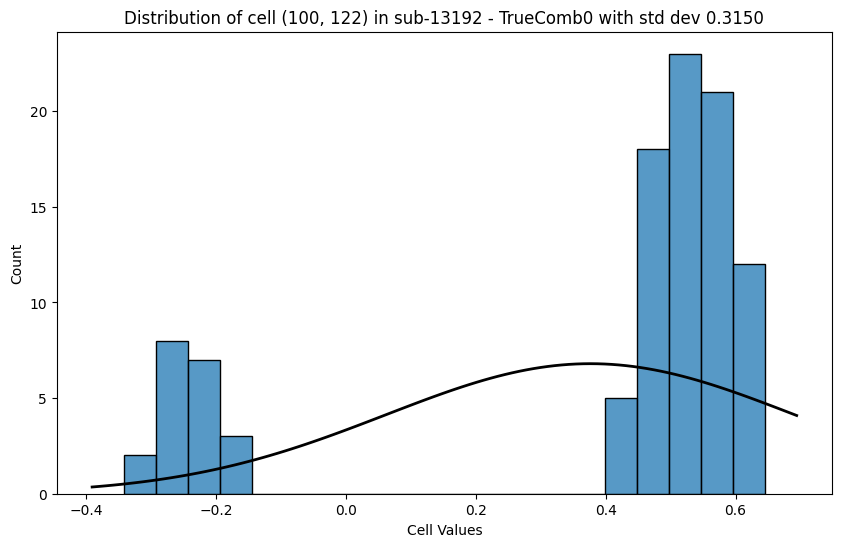

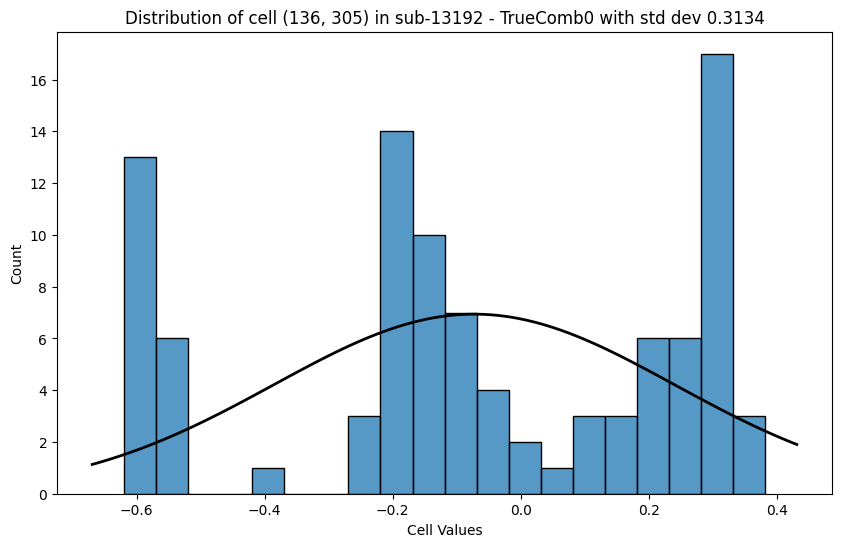

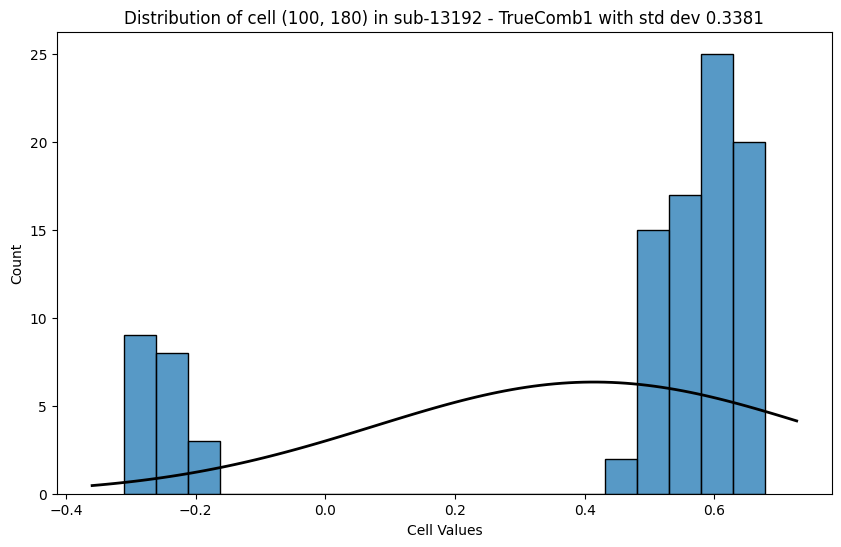

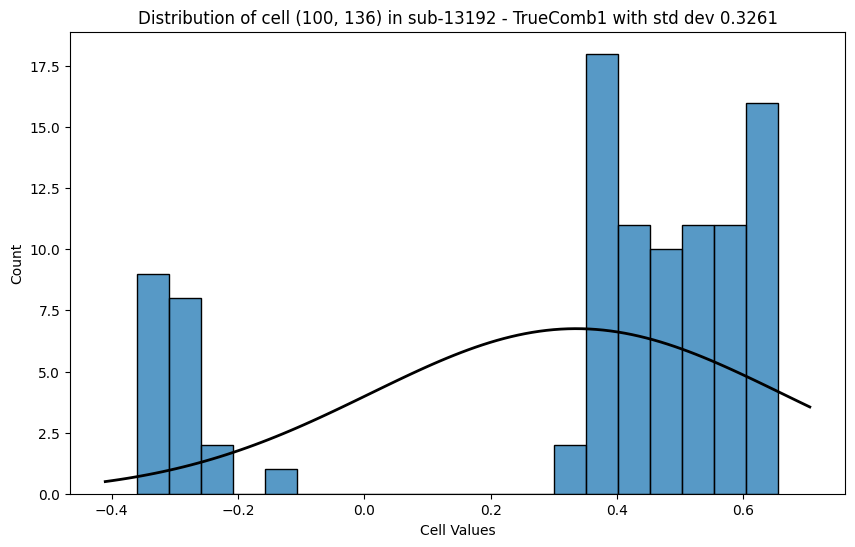

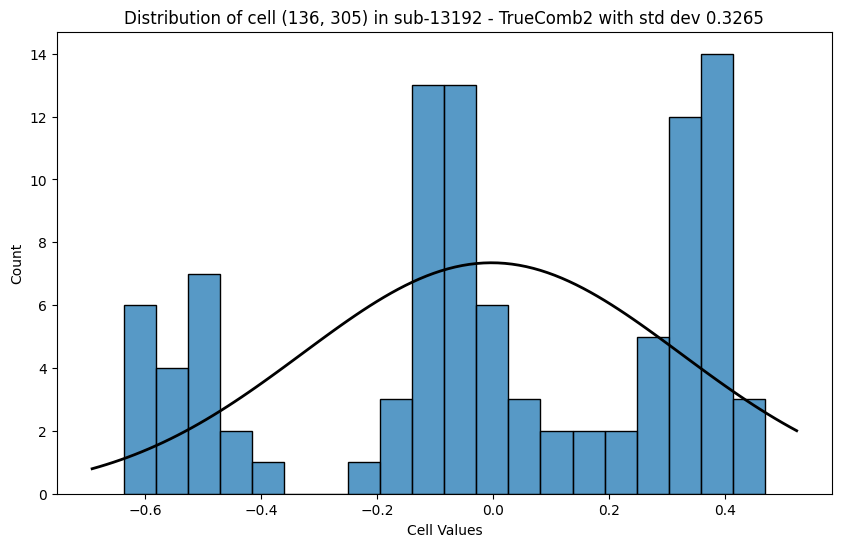

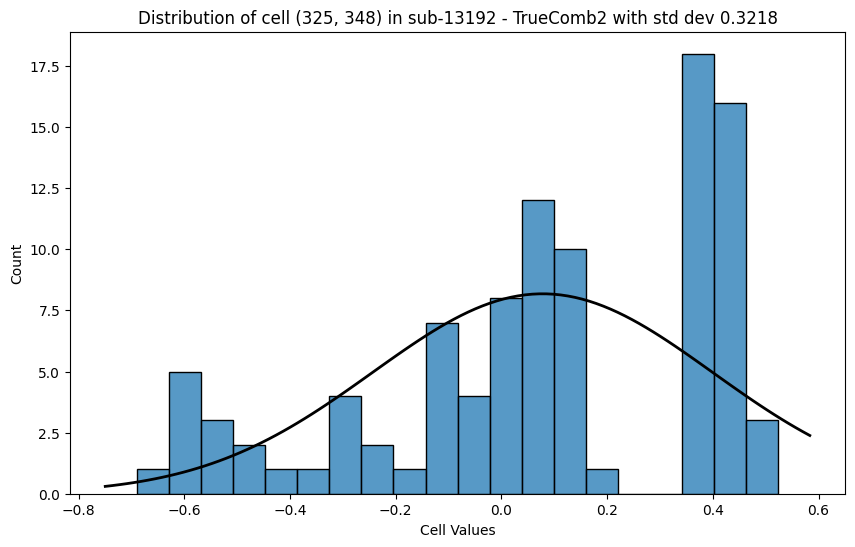

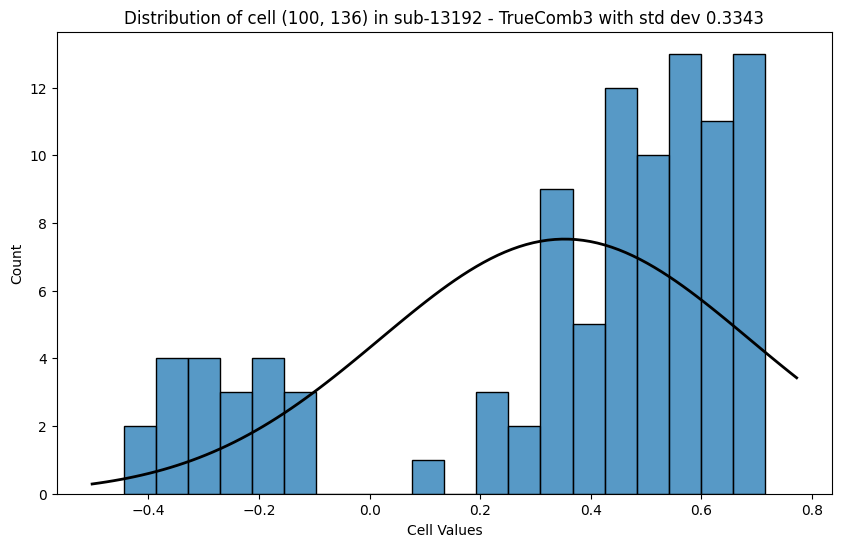

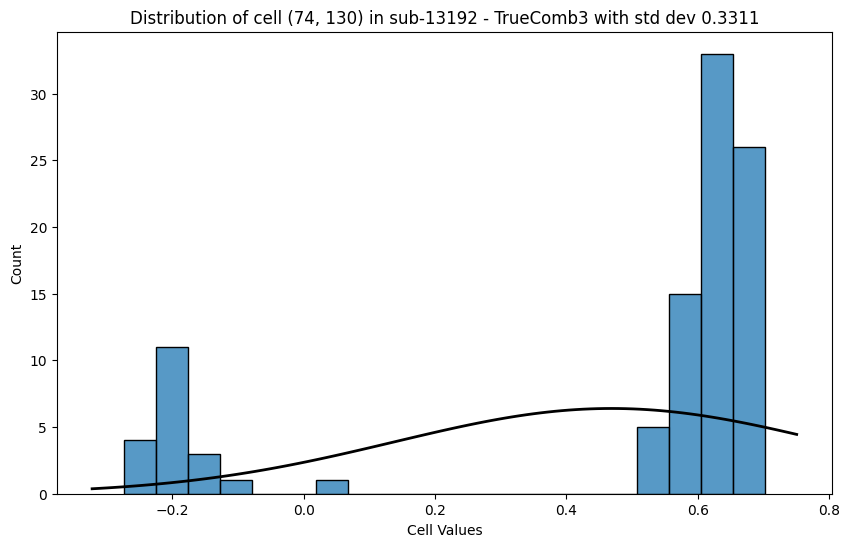

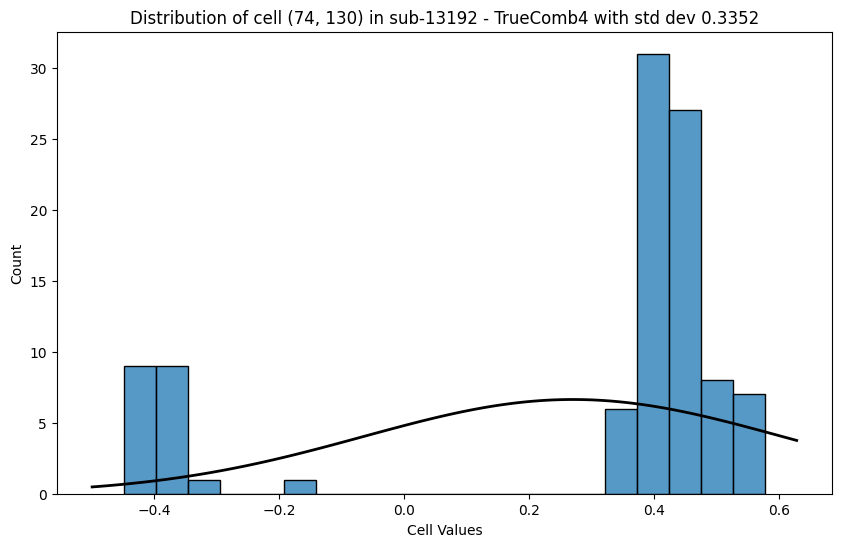

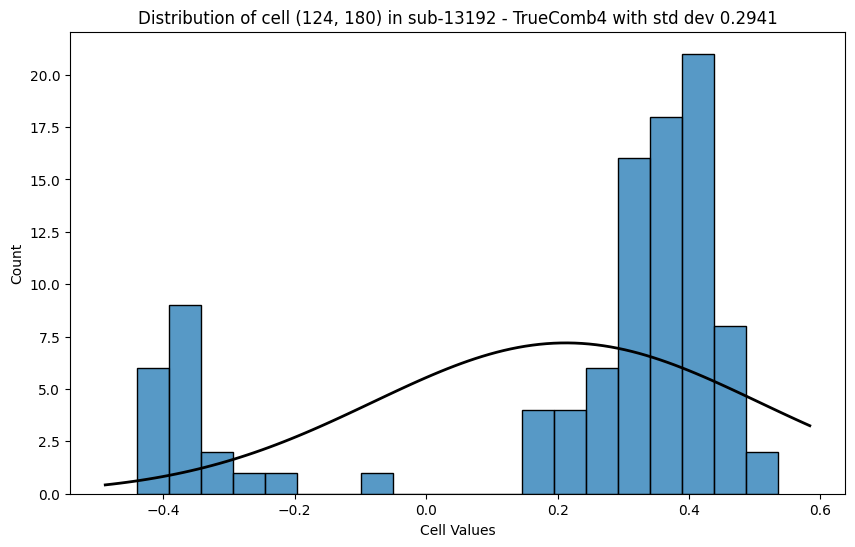

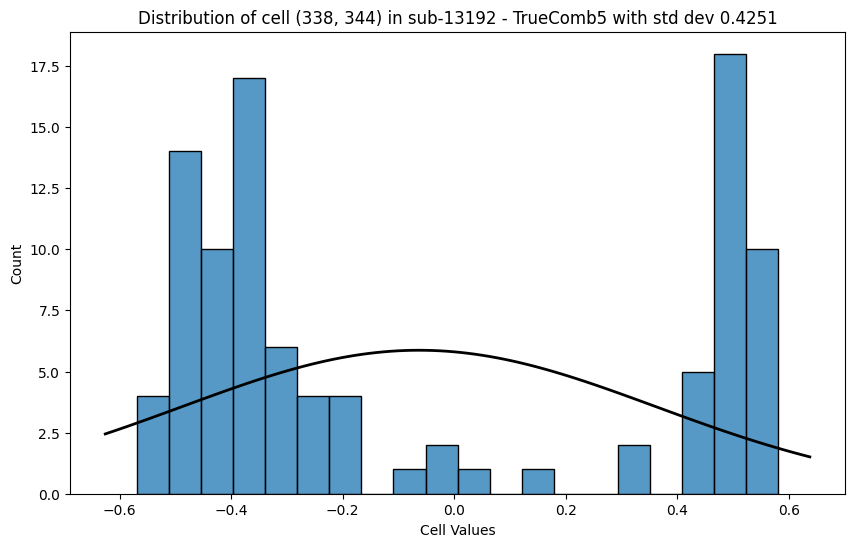

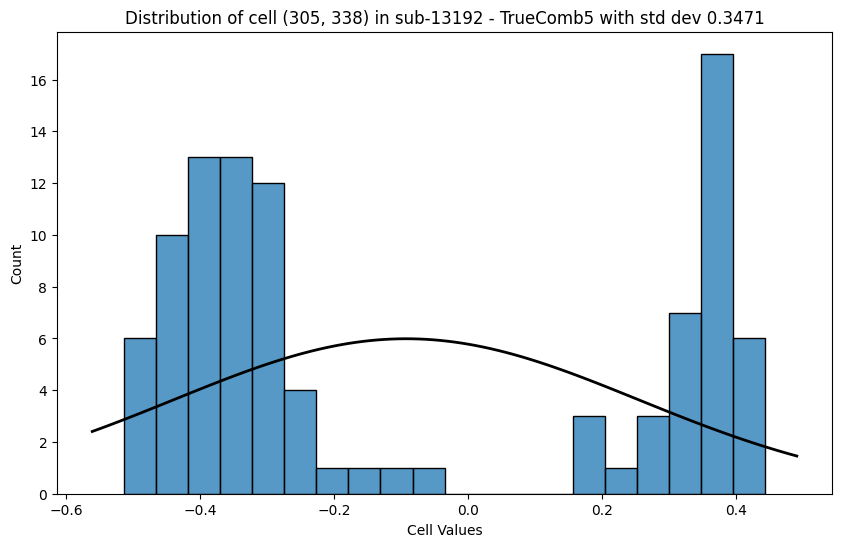

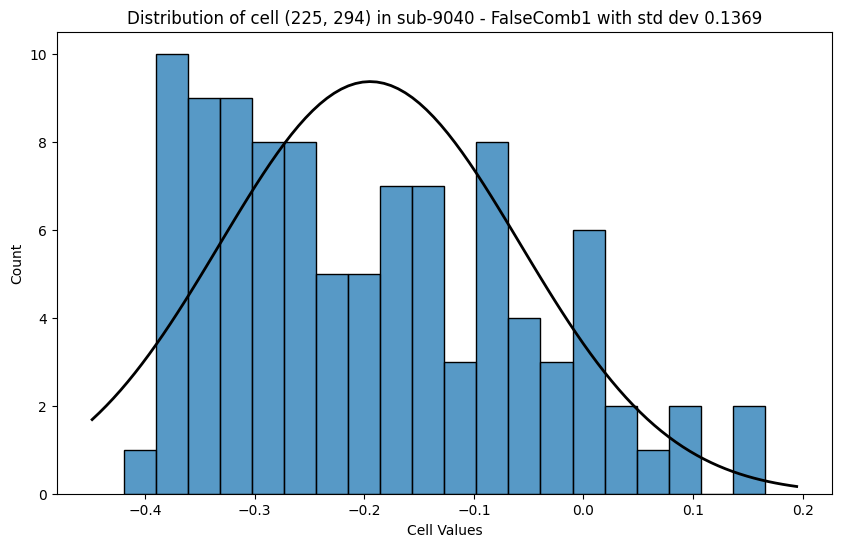

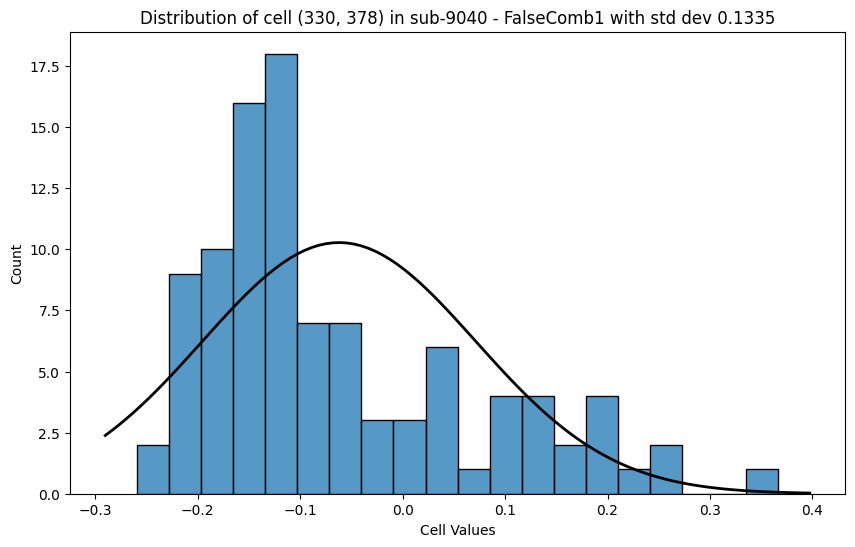

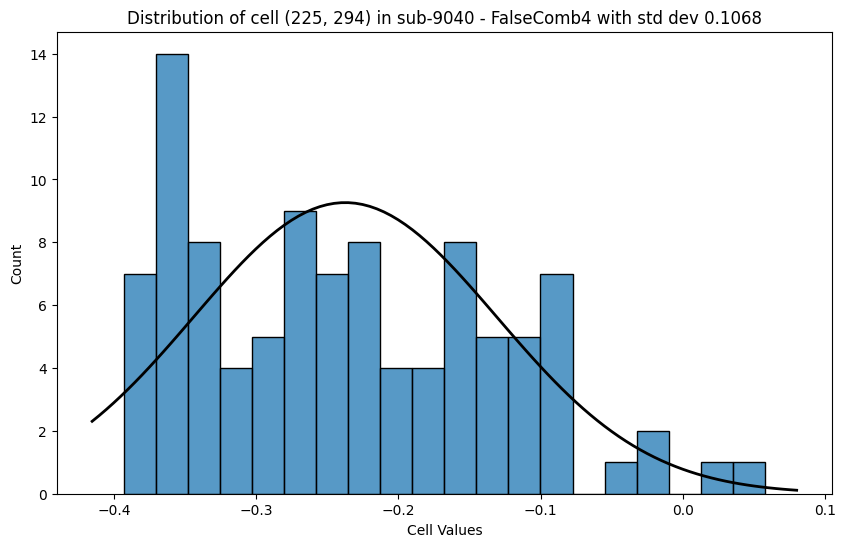

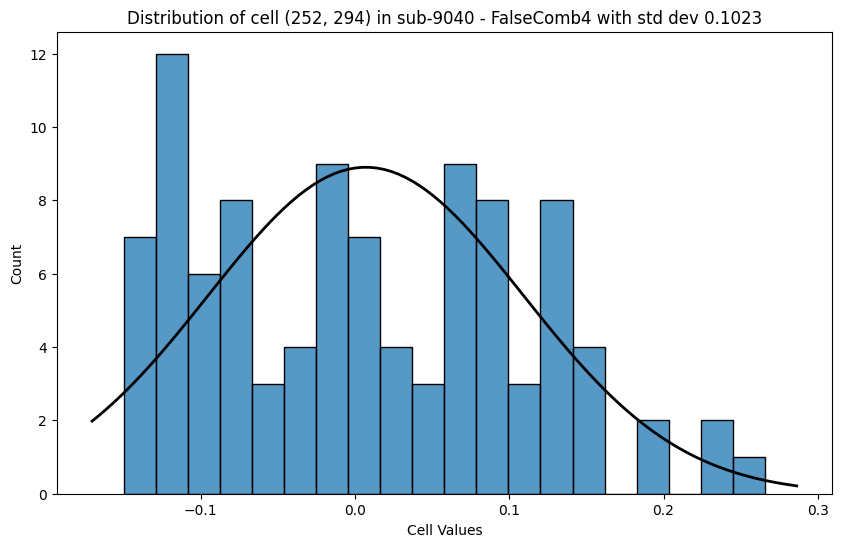

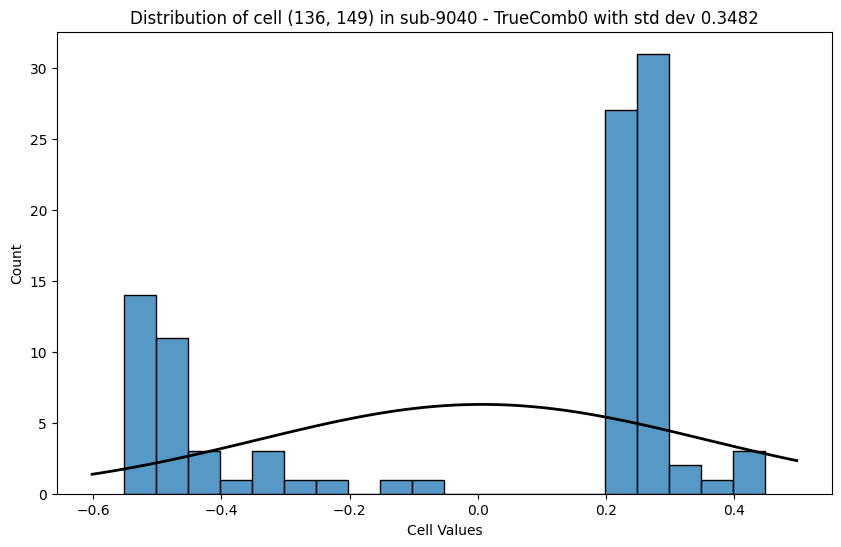

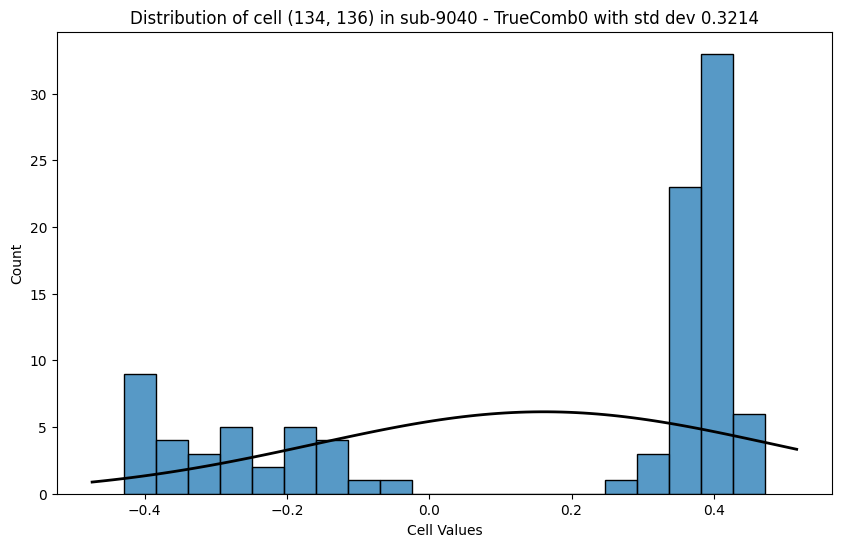

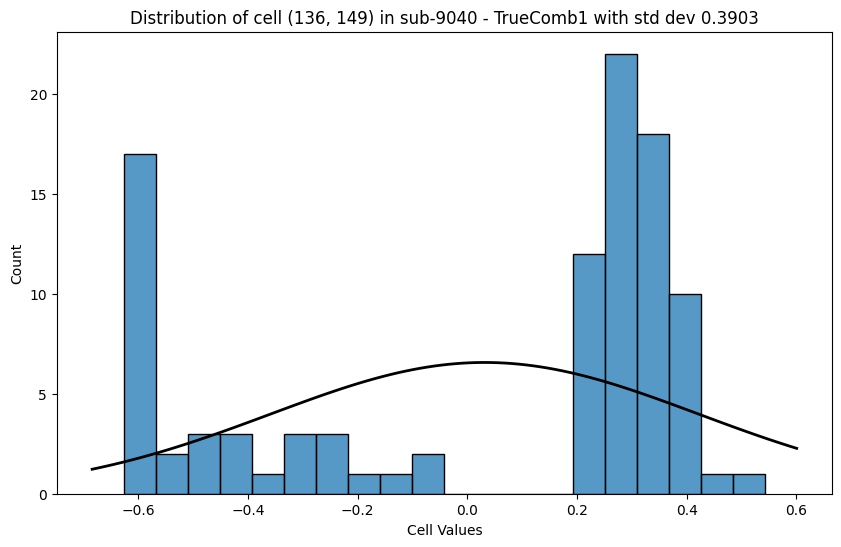

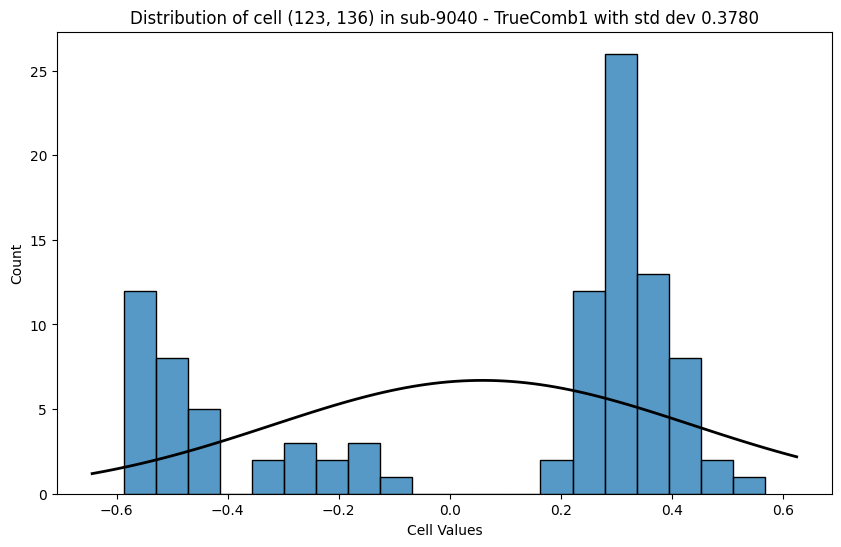

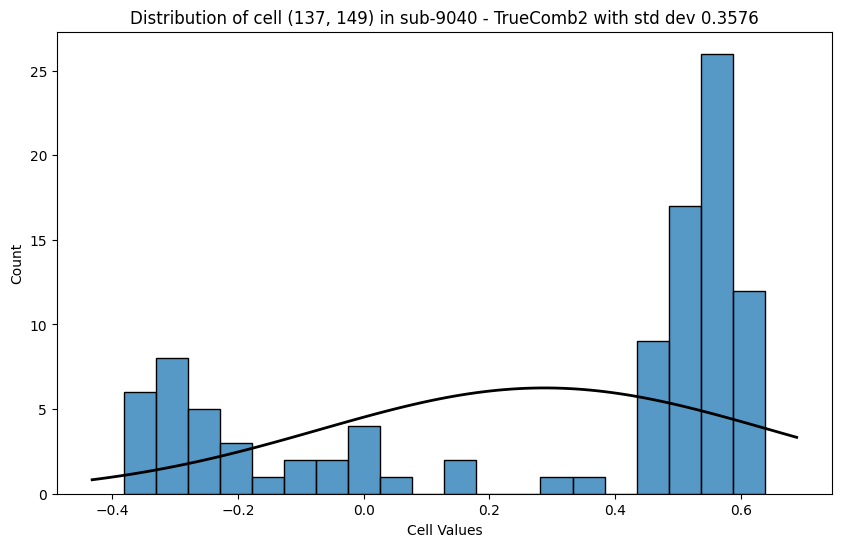

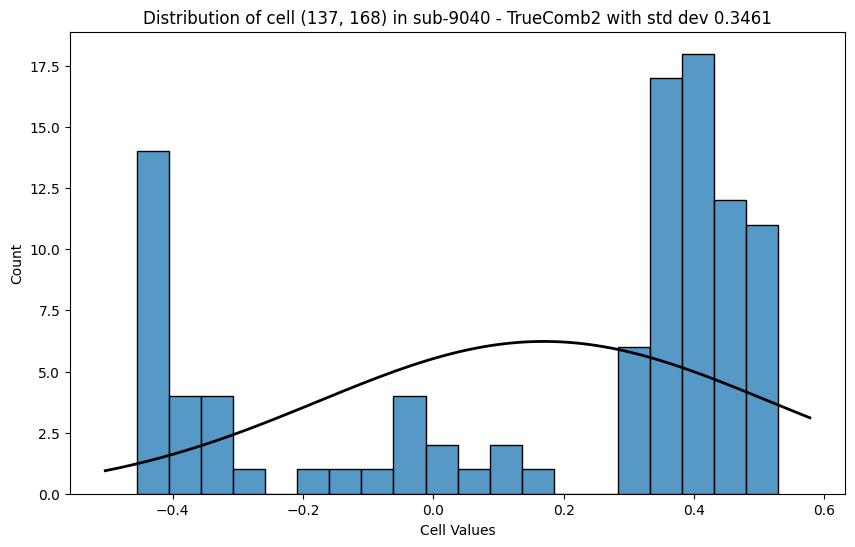

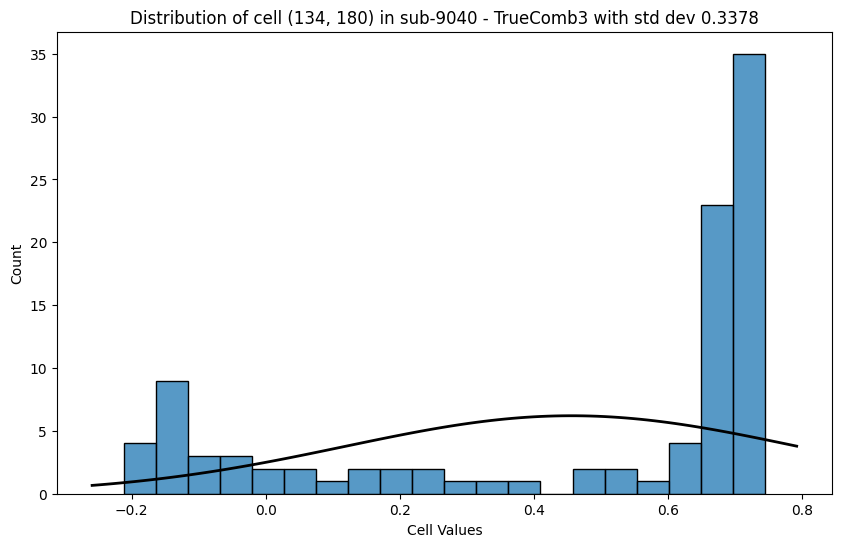

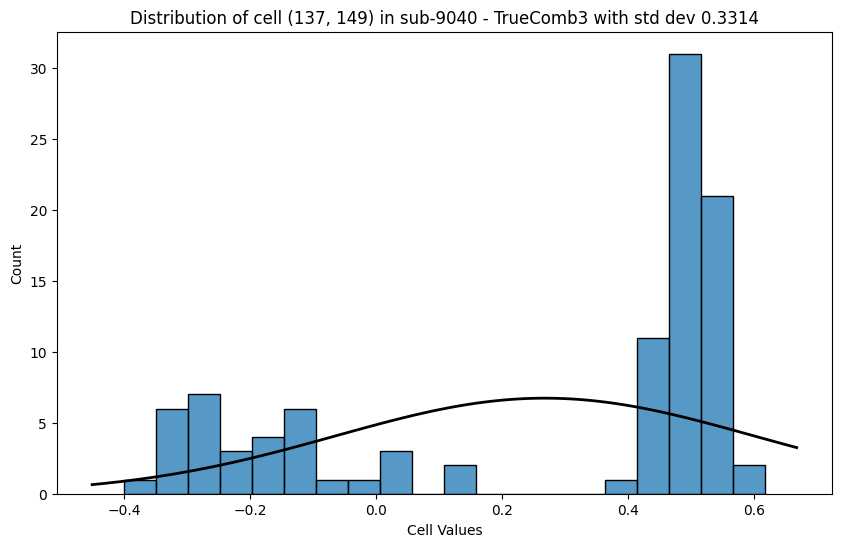

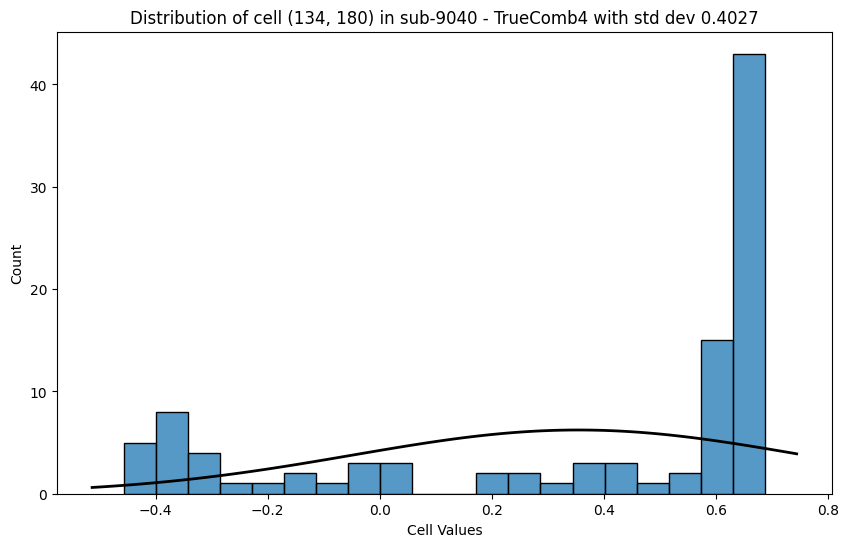

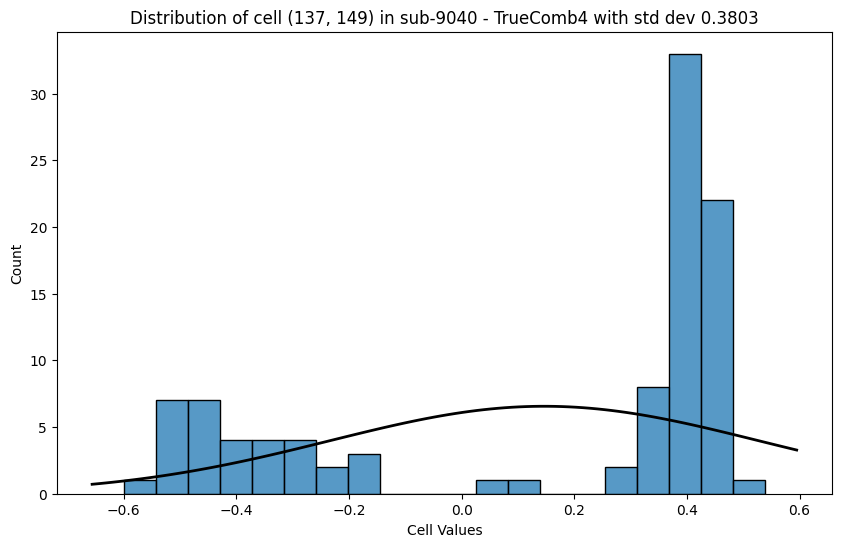

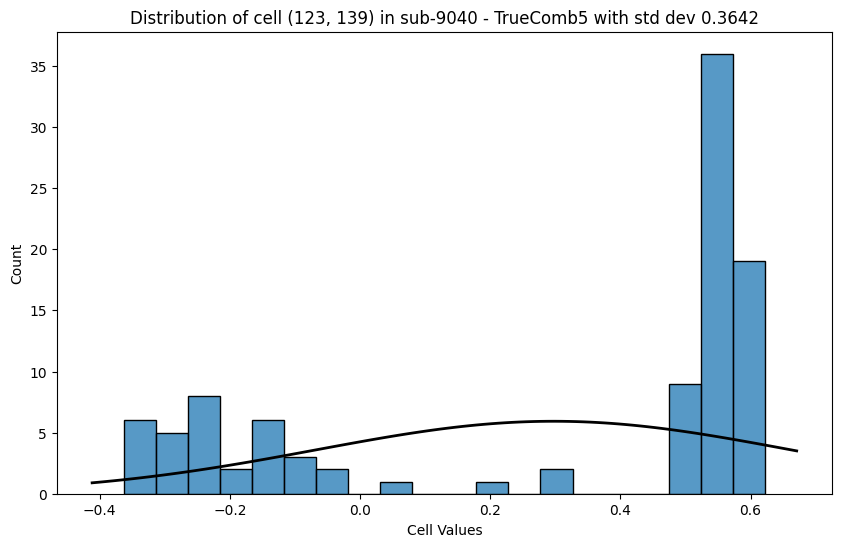

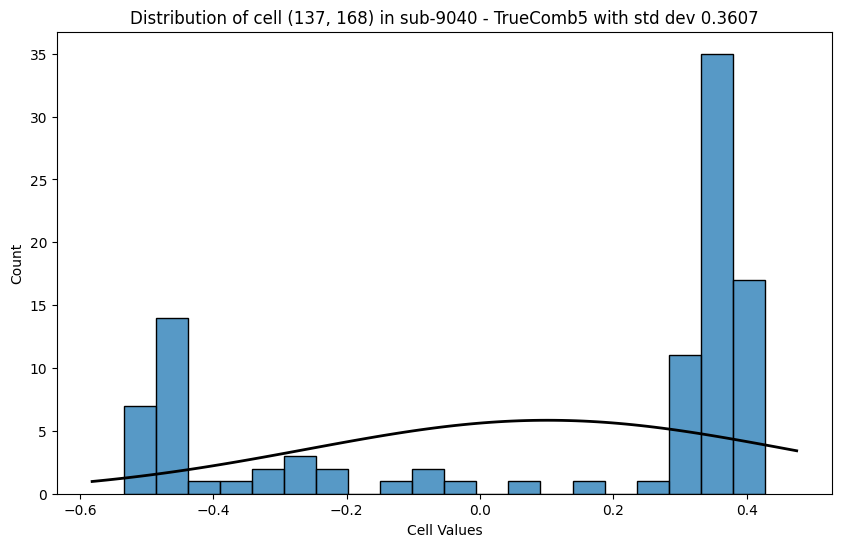

In [3]:
# Perform the standard deviation check for all subjects and conditions
high_std_results = check_all_subjects_conditions()

with open("high_std_results.pkl", "wb") as f:
    pickle.dump(high_std_results, f)

sorted_keys = sorted(high_std_results.keys(), key=lambda x: (x[0], x[1]))

with open("high_std_summary.txt", "w") as f:
    for subject_id, category in sorted_keys:
        data = high_std_results[(subject_id, category)]
        count_str = f"Subject: {subject_id}, Category: {category}, High std cells count: {data['count']}, Percentage: {data['percentage']:.2f}%"
        f.write(count_str)
        print(count_str)

plot_high_std_distributions(high_std_results, top_n=2)

### 3. Check for non-normality of data with a shaphiro test (in subject_matrices.pkl)

I think this doesnt make sense because it says some cells are non-normal when they are because the tolerance of the test is too low

In [8]:
def check_normality(subject_id, category):
    """
    Check the normality of values for all cells in the matrices for a given subject and category.
    
    Parameters:
    subject_id (str): The subject ID.
    category (str): The category name.
    
    Returns:
    tuple: A tuple containing the count of non-normal cells and a list of tuples (i, j) indicating the non-normal cells.
    """
    
    matrices = np.array(all_subjects[subject_id][category])
    non_normal_cells = []
    p_values = []
    rows, cols = matrices.shape[1], matrices.shape[2]
    
    for i in range(rows):
        for j in range(i + 1, cols):  # Only consider the upper triangular part excluding the diagonal
            cell_values = matrices[:, i, j]
            stat, p_value = shapiro(cell_values)

            #print(len(cell_values))  #this tells you how many observations you have per cell. has to be 100 for sub13192
            
            if p_value < 0.05:  # Common threshold for rejecting normality
                non_normal_cells.append((i, j))
                p_values.append(p_value)

    
    non_normal_count = len(non_normal_cells)
    total_upper_triangular_cells = rows * (rows - 1) // 2
    non_normal_percentage = (non_normal_count / total_upper_triangular_cells) * 100
    
    # print(f" total count {non_normal_count} of non-normal cells for {subject_id}, {category}")
    # print(f" that represents {non_normal_percentage} % ")
    
    return non_normal_cells, non_normal_count, non_normal_percentage, p_values

def check_all_for_normality():
    """
    Check the normality of values for all cells in all matrices for all subjects and categories.
    
    Returns:
    dict: A dictionary where keys are (subject_id, category) tuples and values are lists of non-normal cells.
    """
    non_normal_results = {}
    
    for subject_id in all_subjects.keys():
        for category in all_subjects[subject_id].keys():
            non_normal_cells, non_normal_count, non_normal_percentage, p_values = check_normality(subject_id, category)
            non_normal_results[(subject_id, category)] = {
                'count': non_normal_count,
                'cells': non_normal_cells,
                'percentage': non_normal_percentage,
                'p_values': p_values,
            }
    
    return non_normal_results


# Plot the distributions for the most non-normal cells
def plot_non_normal_distributions(non_normal_results, top_n=5):
    """
    Plot the distributions of the most non-normal cells for visualization.
    
    Parameters:
    non_normal_results (dict): The results of the normality check.
    top_n (int): The number of most non-normal cells to plot.
    """
    for subject_id, category in sorted_keys:
        data = non_normal_results[(subject_id, category)]
        non_normal_cells = data['cells']
        p_values = data['p_values']
        
        # Sort by p-values to get the most non-normal cells
        sorted_indices = np.argsort(p_values)
        top_non_normal_cells = [non_normal_cells[i] for i in sorted_indices[:top_n]]
        
        for cell in top_non_normal_cells:
            i, j = cell
            cell_values = np.array(all_subjects[subject_id][category])[:, i, j]
  
            plt.figure(figsize=(10, 6))

             #sns.histplot(cell_values, kde=False, stat='density')
            sns.histplot(cell_values, kde=False, stat='count', bins=20)  # Use 'count' for correct histogram
            mu, std = norm.fit(cell_values)
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, std)
            plt.plot(x, p * len(cell_values) * (xmax - xmin) / 20, 'k', linewidth=2)  # Adjust the plot to match histogram
            title = f"Distribution of cell ({i}, {j}) in {subject_id} - {category}"
            plt.suptitle(title)
            plt.title(f"total number of obs {len(cell_values)}", fontsize=8)
            plt.xlabel("Cell Values")
            plt.ylabel("Count")
            plt.show()




In [10]:
# Perform the normality check for all subjects and conditions
non_normal_results = check_all_for_normality()
non_normal_results.keys()

NameError: name 'all_subjects' is not defined

In [9]:
# Plot the distributions for the most non-normal cells
plot_non_normal_distributions(non_normal_results, top_n=5)

NameError: name 'non_normal_results' is not defined

In [73]:
sorted_keys = sorted(non_normal_results.keys(), key=lambda x: (x[0], x[1]))

for subject_id, category in sorted_keys:
    data = non_normal_results[(subject_id, category)]
    str = f"Subject: {subject_id}, {category}, Non-normal cells count: {data['count']}, Percentage: {data['percentage']:.2f}%"
    print(str)

Subject: sub-01, FalseComb0, Non-normal cells count: 10376, Percentage: 13.00%
Subject: sub-01, FalseComb1, Non-normal cells count: 7087, Percentage: 8.88%
Subject: sub-01, FalseComb2, Non-normal cells count: 10628, Percentage: 13.32%
Subject: sub-01, FalseComb3, Non-normal cells count: 10650, Percentage: 13.35%
Subject: sub-01, FalseComb4, Non-normal cells count: 10254, Percentage: 12.85%
Subject: sub-01, FalseComb5, Non-normal cells count: 9826, Percentage: 12.31%
Subject: sub-01, TrueComb0, Non-normal cells count: 12493, Percentage: 15.66%
Subject: sub-01, TrueComb1, Non-normal cells count: 9061, Percentage: 11.35%
Subject: sub-01, TrueComb2, Non-normal cells count: 7969, Percentage: 9.99%
Subject: sub-01, TrueComb3, Non-normal cells count: 6213, Percentage: 7.79%
Subject: sub-01, TrueComb4, Non-normal cells count: 7642, Percentage: 9.58%
Subject: sub-01, TrueComb5, Non-normal cells count: 12079, Percentage: 15.14%
Subject: sub-13192, FalseComb0, Non-normal cells count: 12898, Perce

In [42]:
with open("non_normal_results.pkl", "wb") as f:
    pickle.dump(non_normal_results, f)


In [37]:
# Save the results to a file
with open("non_normal_results.txt", "w") as f:
    for (subject_id, category), cells in non_normal_results.items():
        f.write(f"Subject: {subject_id}, Category: {category}\n")
        for (i, j) in cells:
            f.write(f"  Cell ({i}, {j}) does not follow a normal distribution\n")
        f.write("\n")


Results have been saved to non_normal_results.txt


### Not used and todo

- look up Median absolute deviation
- calculate confidence interval based on the empirical data (as opposed to analytical)??
- distribution quantiles
- significant digits maps
- netcdf